# Dynamic pricing

* A pricing strategy that adjusts the price of a product or service in real-time
* Based on factors:
  * Market demand
  * Competition
  * Customer behaviour
* Goal is to maximize profits 
  * By finding the optimal price point that customers are willing to pay
  * Costs associated with producing and selling the product


## Algorithms

### Rule-based
Uses pre-defined rules to set prices i.e. increase price if demand is high or lower price if demand is low.

### Time-series forecasting
Uses historical data to forecast future demand and adjust prices accordingly. Takes into account seasonal patterns and trends to optimize pricing.

### Machine Learning algorithm
Use historical data to learn patterns and adjust prices based on predictive models. Can include regression analysis, decision trees, and neural networks.

### Reinforcement Learning algorithm
Uses trial and error to optimize pricing. Algorithm makes decisions based on feedback from customer behaviour and ajusts prices to maximize profit.

### Multi-armed bandit algorithm
Used in situations where there are multiple products or pricing options. Uses trial and error to test different pricing strategies and learns which ones are most effective in maximizing profit.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
import matplotlib.pyplot as plt

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Join datasets

* Brazilian E-commerce data in multiple CSVs

In [2]:
# Read multiple CSV files
FILE_PATH = "/workspaces/dynamic_pricing/data/"

order_items    = pd.read_csv(FILE_PATH + "olist_order_items_dataset.csv")
orders         = pd.read_csv(FILE_PATH + "olist_orders_dataset.csv")
order_payments = pd.read_csv(FILE_PATH + "olist_order_payments_dataset.csv")
products       = pd.read_csv(FILE_PATH + "olist_products_dataset.csv")
customers      = pd.read_csv(FILE_PATH + "olist_customers_dataset.csv")
sellers        = pd.read_csv(FILE_PATH + "olist_sellers_dataset.csv")
product_category_translation = pd.read_csv(FILE_PATH + "product_category_name_translation.csv")

# Merge datasets
merged = order_items.merge(orders, on='order_id') \
                    .merge(order_payments, on=['order_id']) \
                    .merge(products, on='product_id') \
                    .merge(customers, on='customer_id') \
                    .merge(sellers, on='seller_id') \
                    .merge(product_category_translation, on='product_category_name')

# Save the consolidated dataset to a CSV file
merged.to_csv(FILE_PATH + 'brazilian_ecommerce_dataset.csv', index=False)

In [3]:
def prepare_dataset_random_forest(dataset):
    # Load the dataset
    df = pd.read_csv(dataset)
    
    # Preprocess the data
    # Drop irrelevant columns and handle missing data
    df = df.drop(['seller_id', 'freight_value'], axis=1)
    df = df[df['customer_state'].isin(["SP","RJ","MG"])]
    df = df[['product_category_name','product_photos_qty','product_weight_g', 'product_length_cm','product_height_cm','product_width_cm','customer_state','price']]
    df = df.dropna()

    # Remove outliers
    df = df[(df['price'] >= df['price'].quantile(0.05)) & (df['price'] <= df['price'].quantile(0.95))]

    # Convert categorical variables to numerical values
    df = pd.get_dummies(df, columns=['product_category_name', 'customer_state'])
    return df

def prepare_dataset_prophet(dataset):
    # Load the dataset
    df = pd.read_csv(dataset)
    
    # Preprocess the data
    # Drop irrelevant columns and handle missing data
    df = df.drop(['seller_id', 'freight_value'], axis=1)
    df = df.dropna()

    # For simplicity taking only 10k rows of data
    df = df[:10000]

    # Convert categorical variables to numerical values
    df = pd.get_dummies(df, columns=['product_category_name', 'customer_state'])  
    return df  

## Build and train models to predict pricing

### 1. Random Forest Regressor

* MAE is 13.381

In [4]:
df = prepare_dataset_random_forest(FILE_PATH + "brazilian_ecommerce_dataset.csv")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('price', axis=1), df['price'], test_size=0.2, random_state=42)

# Train a machine learning model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate RF model
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean absolute error: {mae:.3f}")

Mean absolute error: 13.381


### 2. Time-series forecasting

* Use Meta (formally Facebook) Prophet

In [13]:
df = prepare_dataset_prophet(FILE_PATH + "brazilian_ecommerce_dataset.csv")

# Train a time series forecasting model for each product & save those models
forecast_models = {}
unique_product_ids = df['product_id'].unique()

# For demonstration & simplicity taking only 200 products
unique_product_ids = unique_product_ids[0:200]
for product in unique_product_ids:
    product_df = df[df['product_id'] == product].copy()
    # Aggregate sales data by date
    product_df['order_purchase_date'] = pd.to_datetime(product_df['order_purchase_timestamp']).dt.date
    sales_data = product_df.groupby(['order_purchase_date']).agg({'price': 'sum'}).reset_index()
    sales_data = sales_data.rename(columns={'order_purchase_date': 'ds', 'price': 'y'})
    if len(sales_data)>=50:
      # Train a time series forecasting model
      m = Prophet()
      m.fit(sales_data)
      forecast_models[product] = m

10:58:16 - cmdstanpy - INFO - Chain [1] start processing
10:58:16 - cmdstanpy - INFO - Chain [1] done processing
10:58:16 - cmdstanpy - INFO - Chain [1] start processing
10:58:16 - cmdstanpy - INFO - Chain [1] done processing
10:58:16 - cmdstanpy - INFO - Chain [1] start processing
10:58:16 - cmdstanpy - INFO - Chain [1] done processing
10:58:16 - cmdstanpy - INFO - Chain [1] start processing
10:58:16 - cmdstanpy - INFO - Chain [1] done processing
10:58:16 - cmdstanpy - INFO - Chain [1] start processing
10:58:17 - cmdstanpy - INFO - Chain [1] done processing
10:58:17 - cmdstanpy - INFO - Chain [1] start processing
10:58:17 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Use the forecast models to predict prices for each product
for product in forecast_models:
    m = forecast_models[product]
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    future_prices = forecast[['ds', 'yhat']].tail(365)
    mean_price = future_prices['yhat'].mean()
    dynamic_price = mean_price * 1.1 # set dynamic price 10% higher than mean price
    
    print("Product:", product)
    print("Dynamic price:", dynamic_price)

Product: c6dd917a0be2a704582055949915ab32
Dynamic price: 103.37769087411569
Product: 601a360bd2a916ecef0e88de72a6531a
Dynamic price: 86.03156420623979
Product: 3354a4e684f5e7199f9407db70ccd92b
Dynamic price: 88.98932193750602
Product: 29427de7f8a9ee983d9dbc51cec569b4
Dynamic price: 57.354667904881964
Product: ee406bf28024d97771c4b1e8b7e8e219
Dynamic price: 171.89676840557786
Product: 165f86fe8b799a708a20ee4ba125c289
Dynamic price: 307.1409642368565


In [15]:
# Aggregate sales data by date
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_timestamp']).dt.date
sales_data = df.groupby(['order_purchase_date']).agg({'price': 'sum'}).reset_index()
sales_data = sales_data.rename(columns={'order_purchase_date': 'ds', 'price': 'y'})

# Remove outliers from sales data using Z-score
sales_data = sales_data[(np.abs(stats.zscore(sales_data['y'])) < 1.5)]

# Train a time series forecasting model
m = Prophet()
m.fit(sales_data)

# Create a future dataframe for forecasting
future = m.make_future_dataframe(periods=365)

# Use the model to make price predictions for each day in the future
forecast = m.predict(future)

# Extract the forecasted prices
forecasted_prices = forecast[['ds', 'yhat']].tail(365)

11:04:50 - cmdstanpy - INFO - Chain [1] start processing
11:04:51 - cmdstanpy - INFO - Chain [1] done processing


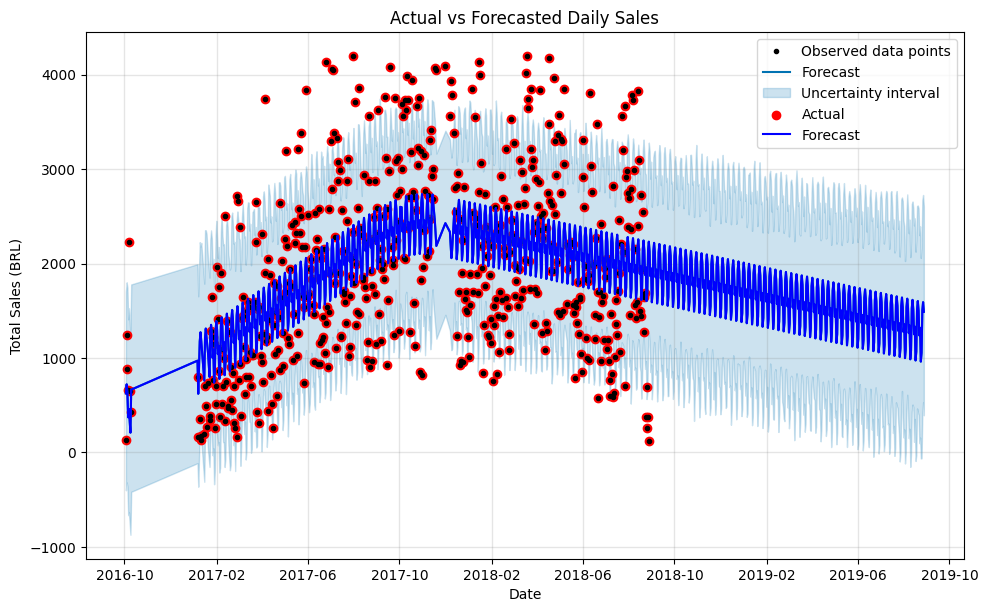

In [16]:
# Plot the forecasted prices
fig = m.plot(forecast)
plt.scatter(sales_data['ds'], sales_data['y'], color='red', label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Forecast')
plt.title('Actual vs Forecasted Daily Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales (BRL)')
plt.legend()
plt.show()

#### Prophet forecast performance

* Not too good (see above plot)
* Can tune performance:
  * Increase number of iterations (above default of 1000). Example: `m.fit(sales_data, iter=2000)`
  * Add additional regressors. Add weather or holiday data - https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html 
  * Adjust seasonality parameters. Increase number of Fourier terms - capture more complex seasonal patterns but risk overfitting
  * Adjust changepoint parameters. Changepoints model changes in trends over time - adding more increases ability to capture sudden changes in trends but risk overfitting
  * Use custom seasonality model. Can improve model accuracy if default seasonalities do not fit your data well
  * Use cross-validation. Evaluate model performance and tune parameters
  * Remove outliers. Remove outliers or use a robust regression algorithm
  * Normalize the data. If data has widely varying scales; normalization can make it perform better
  * Increase number of trees in a Random Forest regressor. Improves model accuracy but risk increasing time to train
* References:
  * https://facebook.github.io/prophet/docs/quick_start.html#python-api  Quick start to Prophet
  * https://rdrr.io/cran/modeltime/man/prophet_params.html  Tuning parameters for Prophet models